# More consistent Regression Models using Huber Loss

In [10]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import numpy as np
import pandas as pd

First we generate synthetic regression data.

In [11]:
from sklearn.datasets import make_regression

X, y = make_regression(
    n_samples=1000, n_features=5, 
    n_informative=4, n_targets=1, 
    shuffle=True, random_state=1234
)


Then split into train and test sets.

In [12]:
from sklearn.model_selection import train_test_split
idx = np.arange(len(X))
train_idx, test_idx = train_test_split(idx, test_size=0.3, random_state=18)

In [13]:
X_train, X_test = X[train_idx, :], X[test_idx, :]

Next, we take multiple copies of the target, $y$. and insert outliers into each copy. 

In [14]:
def insert_outliers(y, n=0, factor=5):
    """Make a copy of vector y and insert n outliers."""
    
    if n > 0:
        seed = np.random.RandomState(1000)
        idx = np.arange(len(y))
        rand_index = seed.choice(idx, size=n, replace=False)
        multipliers = seed.choice([-1, 1], size=n)
        y_copy = y.copy()
        y_copy[rand_index] = y_copy[rand_index] * factor * multipliers
    else:
        y_copy = y.copy()
        
    return y_copy


# 0-10
n_outliers = np.arange(10)

# Numpy array of shape n_outliers * n_samples
y_outliers = np.row_stack([insert_outliers(y, n=k) for k in n_outliers])
y_outliers = pd.DataFrame(y_outliers)

Histograms for the modified $y$ values:

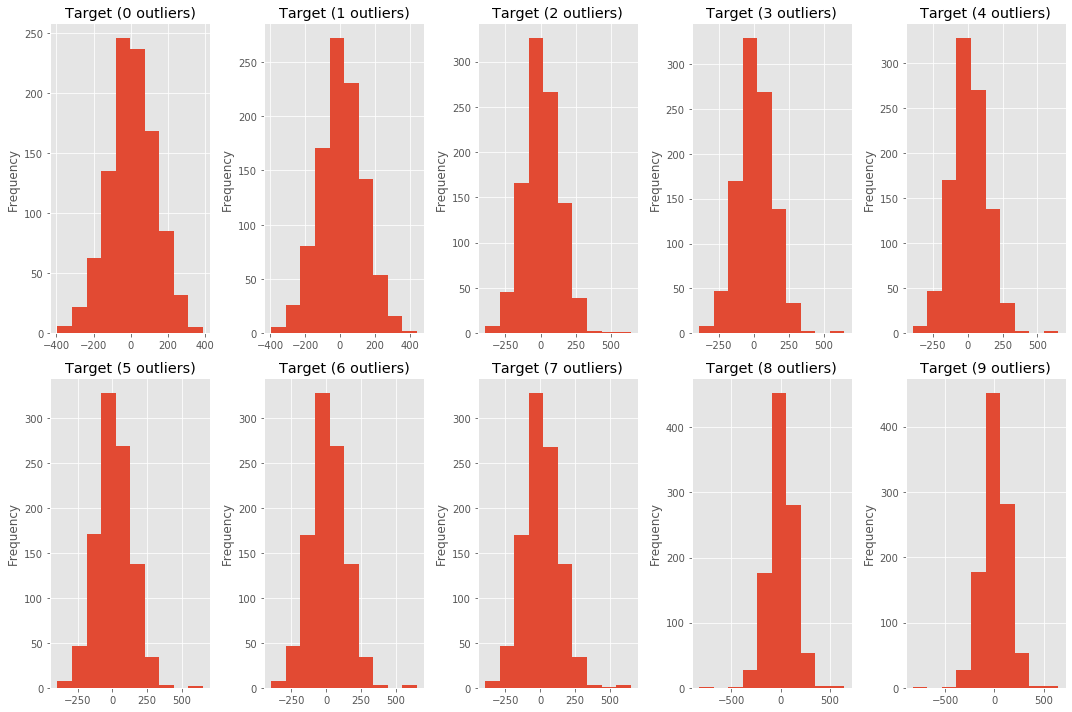

In [15]:
_, axes = plt.subplots(2, 5, figsize=(15, 10))

for k, row in y_outliers.iterrows():
    r, c = divmod(k, 5)
    ax = axes[r][c]
    row.plot(kind='hist', ax=ax, title='Target ({} outliers)'.format(k))

plt.tight_layout()

Next we implement the Approximate Huber Loss function as a pluggable objective function in XGBoost. This function is twice differentiable, so we can calculate it's Gradient and Hessian. It is less sensitive to outliers in the target. 

The function is given by

$L = \sum_{i=1}^{n} \delta^{2} (\sqrt {1 + (\dfrac{y_i - \hat{y_i}} {\delta}})^2 - 1)$

It is a 
Where 

* $n$: number of samples
* $y_i$: The target for the i-th training sample
* $\hat{y_i}$: The predicted value for the i-th training sample.
* $\delta$: The "steepness" constant. Higher values (5+) indicate less sensitivity to outliers.

We use symbolic differentiation as it's much easier to use and less error-prone.

In [16]:
from autograd import grad, hessian
from autograd import numpy as anp

def approx_huber(y, y_hat, delta=5.0):
    """
    Implement the continuous approximation to the Huber loss.
    https://alexisalulema.com/2017/12/07/loss-functions-part-1/
    """
    
    def huber_loss(y_hat):
        loss = 1.0 + anp.square((y - y_hat) / delta)
        loss = anp.sum(delta * delta * (anp.sqrt(loss) - 1))
        return loss
    
    h_grad = grad(huber_loss)(y_hat)
    h_hess = hessian(huber_loss)(y_hat)
    
    # Take the diagonal of the Hessian and make a copy
    # Because xgboost expects a contiguous array
    h_hess = np.diag(h_hess).copy()
    return h_grad, h_hess

In [17]:
from xgboost import XGBRegressor
import seaborn as sns
from sklearn.metrics import r2_score
from tqdm.notebook import tqdm
import seaborn as sns


def score(objective_func, y_train, y_test):
    """Train an XGBoost regressor with a given objective function and return the r2_score for the test set."""
    
    regressor = XGBRegressor(objective=objective_func, random_state=100, 
                             n_estimators=100, max_depth=3, silent=True
                            )
    regressor.fit(X_train, y_train)
    predict = regressor.predict(X_test)

    score = r2_score(predict, y_test)
    return score


scores = []

def score_with_outliers(k):
    """
    Calculate the r2 score using the Huber objective and the MSE objective
    for otherwise same XGBoost regressor.
    """
    y_n = y_outliers.loc[k, :].values
    y_train, y_test = y_n[train_idx], y_n[test_idx]
    
    # It's much faster to use the built-in MSE
    mse_score = score('reg:squarederror', y_train, y_test)
    huber_score = score(approx_huber, y_train, y_test)
    
    scores.append({'n_outliers': k, 'loss': 'mse', 'value': mse_score})
    scores.append({'n_outliers': k, 'loss': 'huber', 'value': huber_score})



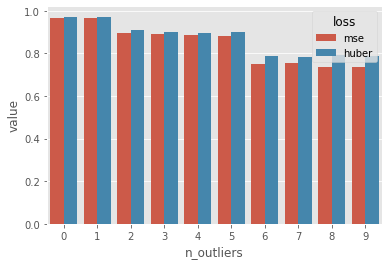

In [18]:
for k in tqdm(n_outliers):
    score_with_outliers(k)
    
scores = pd.DataFrame(scores)
sns.barplot(x='n_outliers', y='value', hue='loss', data=scores)